I utilize publically available census data to perform exploratory data analysis. The purpose is to gain insights into communal well-being in the Indiana population.

Information regarding the PUMS survey and dataset can be found __[here](https://www.census.gov/programs-surveys/acs/microdata/documentation.html)__.


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
pd.set_option("display.precision", 4)
import geopandas as gpd
import matplotlib.pyplot as plt
from functions import get_PUMA_dfs, moe_st_error, recode, group
%matplotlib inline

In [2]:
# Geopandas stuff
geo_data= gpd.read_file("Geo\cb_2018_18_puma10_500k.shp")
# geo_data = gpd.read_file("Geo\County\cb_2018_us_county_500k.shp")
geo_data = geo_data.sort_values(by='PUMACE10')


The Census Bureau uses a modified mean squared error function to calculate the standard errors, margins of errors, and confidence intervals. Information on how PUMS calculate the confidence intervals can be found __[here](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2014_2018AccuracyPUMS.pdf)__.

Below is the function PUMS uses to calculate their standard error.
$$ SE(X) = \sqrt{4/80 * \sum_{r=1}^{80}(X_{r} - X)^{2}} $$
Where:
- $X_{r}$ is one of the replicate weights, r is index
- $X$ is the primary weight

The PUMS survey uses a 90% confidence interval.
$$ LB, UB = X \pm 1.645 * SE(X)$$
Where:
- 1.645 is the z - score for a 90% confidence level
- $1.645 * SE(X)$ is the margin of error (MOE)

The Census Bureau provides 80 replicate weights for error metrics.

The PUMS data dictionary can be found here: __[here](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2014-2018.pdf)__.

There are a large amount of features and most of the labels are non-intuitive. I'll identify variables as they become relevant. 

In [3]:
df = pd.read_csv(r'data\Pums_5_2018.csv'
                 ,na_values='',low_memory=False)

Dropping columns with over 90% missing values. After reviewing the columns fitting this threshold, I decided they would not be of much use for my purposes.

In [4]:
data = df.dropna(axis=1,thresh=(.1*len(df))).copy()

In [5]:
# For geopandas
data = data.rename({'PUMA':'PUMACE10'},axis=1)

Data shape for reference

In [6]:
data.shape

(333546, 263)

Checking that columns have appropriate datatypes, for computational efficiency

In [7]:
data.dtypes.value_counts()

int64      197
float64     62
object       4
dtype: int64

In [8]:
# Creating a column differentiating those below the poverty threshold
data['pov_bool'] = data['POVPIP'] < 100

In [9]:
bin_list = [0, 4, 9, 14, 19, 24, 34, 44, 54, 64, 74, 84, 99]
ages = ['Age 0-4', 'Age 5-9', 'Age 10-14', 'Age 15-19',
        'Age 20-24', 'Age 25-34', 'Age 35-44', 'Age 45-54', 'Age 55-64',
        'Age 65-74', 'Age 75-84', 'Age 85 and over']

In [10]:
# Creating a column grouping people by age using above lists
data['AgeRange'] = pd.cut(data['AGEP'],bin_list,
                         labels=ages,include_lowest=True)

In [11]:
# Coding race values and dropping values.
race_codes = {1:'White', 2:'African American', 3:'American Indian', 4:'Alaska Native',
             5: 'American Indian', 6:'Asian', 7:'Native Hawaiin/Pacific Islander'}
race_lst = list(race_codes.values())
data['RAC1P'] = data['RAC1P'].replace(8,np.NaN).replace(9,np.NaN).map(race_codes)

In [12]:
# Changing the gender column to Male/Female
data['SEX'] = data['SEX'].replace([1],'Male').replace([2],'Female')

The analysis I used to compare my numbers to had the bin sizes below. There is a focus on the older population.

The primary and replicate weights are labeled as follows:
- Primary (1):
    - Person Level:"PWGTP"
- Replicate (80):
    - Person Level:"PWGTP1" - "PWGTP80"

In [13]:
p = 'PWGTP'
w = list(data.filter(regex=r'PWGTP\d+?').columns)

The calculations originally covered 3 areas; this document only contains metrics for the entirity of Indiana. The areas were determined by PUMA codes. PUMA codes represent "Public Use Microdata Areas" and serve to segment populations into subsets of atleast 100,000 people.

Relevant areas:
- Indiana

In [14]:
Idata = data.dropna(axis=0,subset=['AgeRange']).copy()

# Indiana Weighted Sample Size by Age and Gender

In [15]:
pivoted, props = group(Idata,'AgeRange','SEX')
props.style.set_caption('Indiana Weighted Sample Sizeby Age and Gender');

<AxesSubplot:title={'center':'Indiana Weighted Sample Size by Age and Weight'}, xlabel='AgeRange'>

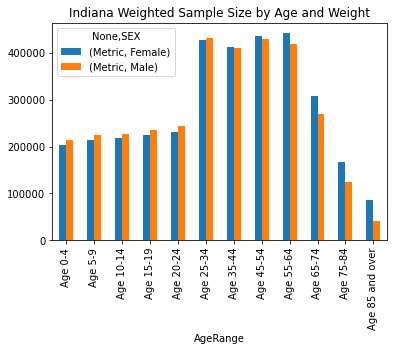

In [16]:
pivoted.plot(kind='bar', title='Indiana Weighted Sample Size by Age and Weight')

# Race

### Indiana Weighted Sample Size by Age and Race

In [17]:
RApivoted,RAprops = group(Idata,'AgeRange','RAC1P')
RAprops.style.set_caption('Indiana Weighted Sample Size by Age and Race');

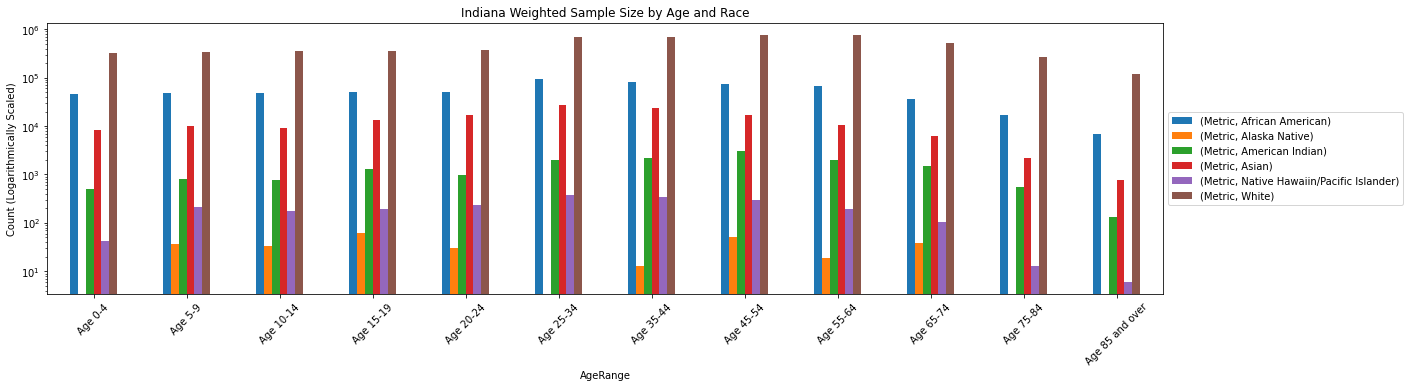

In [18]:
# Note the y is scaled logarithmically to better demonstrate differences
RApivoted.plot(kind='bar',logy=True,ylabel='Count (Logarithmically Scaled)'
        ,figsize=(20,5), title='Indiana Weighted Sample Size by Age and Race',rot=45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Indiana Weighted Sample Size by Gender and Race

In [19]:
GRpivoted,GRprops = group(Idata,'SEX','RAC1P')
GRprops.style.set_caption('Indiana Weighted Sample Size by Gender and Race');

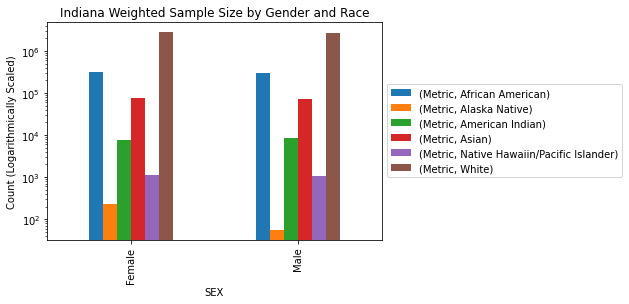

In [20]:
# Logarithmically scaled y axis
GRpivoted.plot(kind='bar',logy=True, ylabel='Count (Logarithmically Scaled)'
       , title='Indiana Weighted Sample Size by Gender and Race',rot=90)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Poverty

### Poverty by Age

In [21]:
PApivoted,PAprops = group(Idata,'AgeRange','pov_bool')
PAprops.style.set_caption('Proportion of Impoverished by Age');

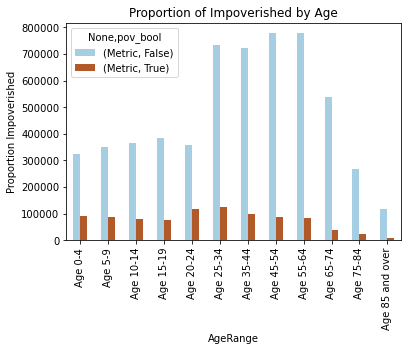

In [22]:
PApivoted.plot(kind='bar', ylabel='Proportion Impoverished',
           title='Proportion of Impoverished by Age',rot=90,colormap='Paired');

### Poverty by Race

In [23]:
PRpivoted,PRprops = group(Idata,'RAC1P','pov_bool')
PRprops.style.set_caption('Proportion of Impoverished by Race');

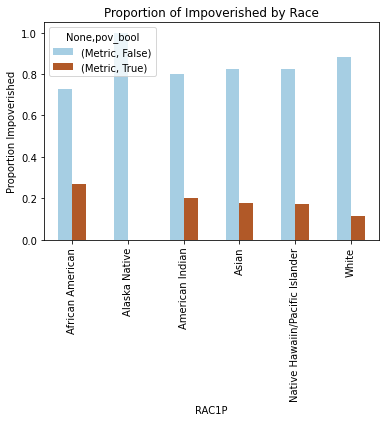

In [24]:
PRprops.plot(kind='bar', ylabel='Proportion Impoverished',
            title='Proportion of Impoverished by Race',rot=90,colormap='Paired');

### Poverty by PUMA

In [25]:
PPpivoted,PPprops = group(Idata,'PUMACE10','pov_bool')
PPprops.style.set_caption('Proportion of Impoverished by PUMA');

In [26]:
# Formatting for geopandas (removing multiindex/renaming cols)
geo_pov = PPprops.reset_index()
geo_pov.columns = geo_pov.columns.droplevel(1)
geo_pov.columns = ['PUMACE10', 'False','True']
geo_data['Pov'] = geo_pov['True']
geo_data;

Text(0.5, 1.0, 'Indiana Poverty Rates by PUMA')

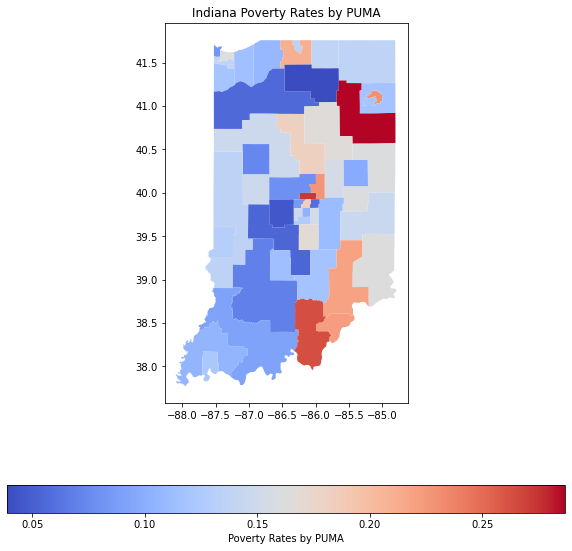

In [27]:
geo_data.plot(cmap='coolwarm',column='Pov',legend=True, figsize=(10,10),
              legend_kwds = {'label':'Poverty Rates by PUMA',
                             'orientation':'horizontal'}
             ).set_title('Indiana Poverty Rates by PUMA')

# Unemployment 

In [28]:
# Excluding the youth
youth_list = [18, 24, 34, 44, 54, 64, 74, 84, 99]
youth = ['Age 18-24', 'Age 25-34', 'Age 35-44', 'Age 45-54', 'Age 55-64', 'Age 65-74', 'Age 75-84', 'Age 85 and over']

In [29]:
Udata = Idata.copy()
# Recoding unemployment values
Udata['ESR'] = Udata['ESR'].apply(recode)

In [30]:
# Creating a column grouping people by age using above lists
Udata['AgeRange'] = pd.cut(Udata['AGEP'],youth_list,
                         labels=youth,include_lowest=True)
# Dropping missing values depending on age range and esr subsets
Udata = Udata.dropna(subset=['AgeRange', 'ESR'])
Udata['ESR'].value_counts()

Other    152535
Unemp      7703
Name: ESR, dtype: int64

### Unemployment by Age

In [31]:
UApivoted,UAprops = group(Udata,'AgeRange','ESR')
UAprops.style.set_caption('Proportion of Unemployed by Age');

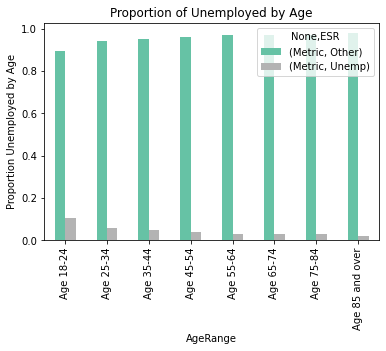

In [32]:
UAprops.plot(kind='bar', ylabel='Proportion Unemployed by Age',
           title='Proportion of Unemployed by Age',rot=90,colormap='Set2');

### Unemployment by Race

In [33]:
URpivoted,URprops = group(Udata,'RAC1P','ESR')
URpivoted.style.set_caption('Proportion of Unemployed by Race');

In [34]:
# Grouping by age groups and unemployment status
age_dist = pd.DataFrame(Udata.groupby(['RAC1P','ESR']).sum())

In [35]:
# MOE standard error confidence interval
URout = moe_st_error(age_dist[p],age_dist[w]).reset_index()
URout['Metric'] = (URout['Metric'])

In [36]:
# Pivot on age groups and unemployment status
UR = pd.pivot_table(URout[['RAC1P','ESR','Metric']],
                   index = 'RAC1P',columns = 'ESR')
# Calculate proportions
URprop = UR.apply(lambda x: x / UR.sum(axis=1))
# Remove semicolon below to output
URprop.style.set_caption('Proportion of Unemployed by Race');

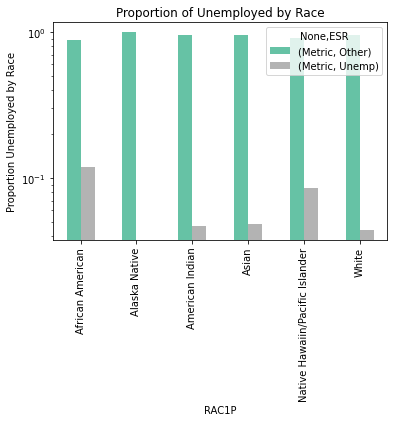

In [37]:
URprops.plot(kind='bar',logy=True,ylabel='Proportion Unemployed by Race',
           title='Proportion of Unemployed by Race',rot=90,colormap='Set2');

### Unemployment by PUMA

In [38]:
UPpivoted,UPprops = group(Udata,'PUMACE10','ESR')
UPprops.style.set_caption('Proportion of Impoverished by PUMA}');

In [39]:
# Formatting for geopandas (removing multiindex/renaming cols)
geo_pov = UPprops.reset_index()
geo_pov.columns = geo_pov.columns.droplevel(1)
geo_pov.columns = ['PUMACE10', 'False','True']
geo_data['Unemp'] = geo_pov['True']
# geo_data;

Text(0.5, 1.0, 'Indiana Unemployment Rates by PUMA')

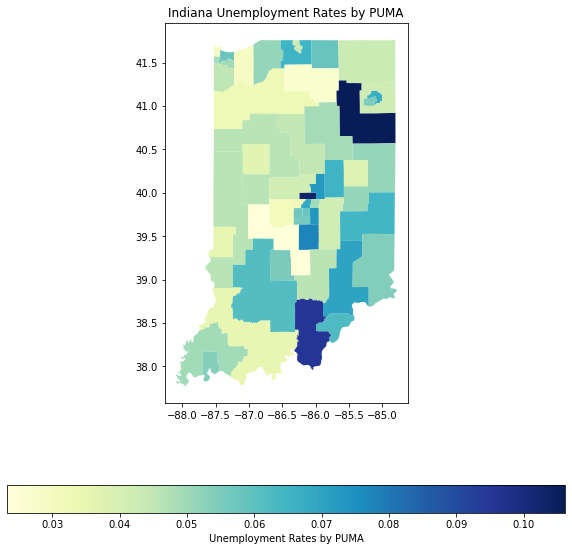

In [40]:
geo_data.plot(cmap = 'YlGnBu',column='Unemp',legend=True, figsize=(10,10),
              legend_kwds = {'label':'Unemployment Rates by PUMA',
                             'orientation':'horizontal'}
             ).set_title('Indiana Unemployment Rates by PUMA')

# Income

In [41]:
Incdata = Udata.copy()
Incdata.shape

(160238, 265)

In [42]:
# First checking Wage and Total income columns to determine which has more missing values.
Incdata[['WAGP','PINCP']] = Incdata[['WAGP','PINCP']].replace(0,np.NaN,)
Incdata[['WAGP','PINCP']].notna().sum() # PINCP (Total income) has more data

WAGP     150582
PINCP    158142
dtype: int64

In [43]:
# Dropping rows based on the total income column
Incdata = Incdata.dropna(subset=['PINCP'])
Incdata.shape

(158142, 265)

In [44]:
Incdata['PINCP'].mean()

46231.25514411099

### Income by PUMA

In [45]:
# IApivoted,IAprops = group(Incdata,'AgeRange', 'PINCP','mean')

<AxesSubplot:title={'center':'PINCP'}, xlabel='AgeRange'>

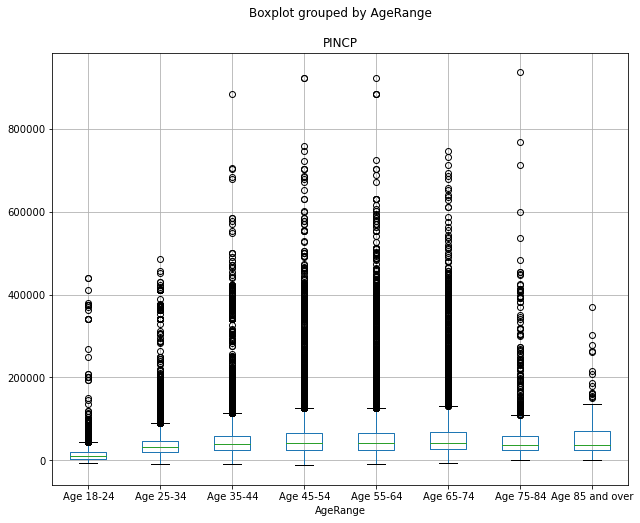

In [46]:
fig, ax = plt.subplots(figsize=(10,8))
Incdata.boxplot(column='PINCP', by='AgeRange',ax=ax)

<AxesSubplot:title={'center':'PINCP'}, xlabel='AgeRange'>

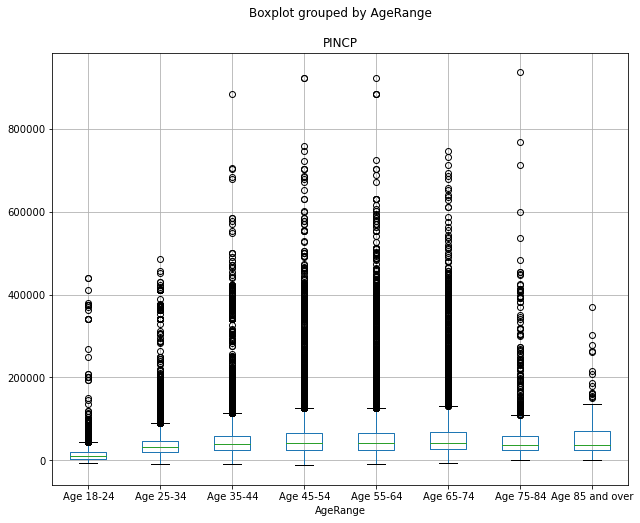

In [47]:
fig, ax = plt.subplots(figsize=(10,8))
Incdata.boxplot(column='PINCP', by='AgeRange',ax=ax)

In [48]:
# fig, ax = plt.subplots(figsize=(10,8))
# incdata = Incdata.copy()
# incdata['PINCP'] = np.log(incdata['PINCP'])
# incdata.hist(column = 'PINCP', ax=ax,
#             bins =30, weights=incdata['PWGTP'])

In [49]:
# incdata

In [50]:
geo_data['Mean Income'] = Incdata.groupby(['PUMACE10'])['PINCP'].median().reset_index().drop(columns=['PUMACE10'])

Text(0.5, 1.0, 'Indiana Unemployment Rates by PUMA')

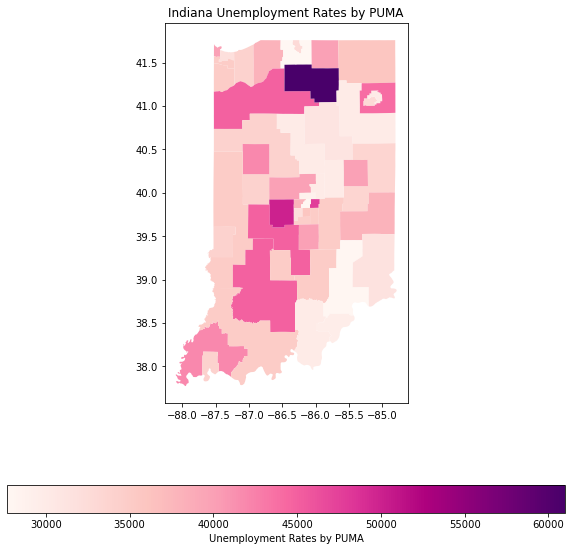

In [51]:
geo_data.plot(cmap = 'RdPu',column='Mean Income',legend=True, figsize=(10,10),
              legend_kwds = {'label':'Unemployment Rates by PUMA',
                             'orientation':'horizontal'}
             ).set_title('Indiana Unemployment Rates by PUMA')